# Airbnb New Users Bookings

## Project Overview
New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In this competition, the challenge is to predict in which country a new user will make his or her first booking. The data is composed of a list of users along with their demographics, web session records, and some summary statistics. All the users in this dataset are from the USA.

For each new user, a maximum of 5 predictions on the country of the first booking will be accepted. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other' (there was a booking, but is to a country not included in the list). The destination country predictions must be ordered such that the most probable destination country goes first.

### Evaluation Metric
The evaluation metric is NDCG (Normalized discounted cumulative gain) @ 5. For each new user, a maximum of 5 predictions on the country of the first booking are made. Predictions are ordered in decending order on probability. The earlier a correct prediction is made, the higher the score is. No correct prediction in 5 attempts results in score 0.

In [1]:
import math

print "%15s %8s"%("Correct Prediction Order", "Score")
print "-------------------------- --------"                  
for i in range(1,6):
    print "%8d %26.5f"%(i, (pow(2,1) - 1)*1. / math.log(i+1,2))
print "   %12s %18.5f"%("no prediction",0.)

Correct Prediction Order    Score
-------------------------- --------
       1                    1.00000
       2                    0.63093
       3                    0.50000
       4                    0.43068
       5                    0.38685
   no prediction            0.00000


## Data Import and Exploration

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd

import random
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# SK-learn libraries for data processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load data using pandas.
train_data = pd.read_csv('data/train_users_2.csv')
test_data = pd.read_csv('data/test_users.csv')
print "Train data shape: {0}".format(train_data.shape)
print "--------------Train Data----------------------"
print train_data.info()
print "----------------------------------------------"

print "\n"
print "Test data shape: {0}".format(test_data.shape)
print "---------------Test Data----------------------"
print test_data.info()
print "----------------------------------------------"

Train data shape: (213451, 16)
--------------Train Data----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float

### Analysis of Class Distribution

Check training data to see how classes are distributed. It is obvious the training data is heavily imbalanced. This presented challenges for our models when identifying and predicting the minority classes.

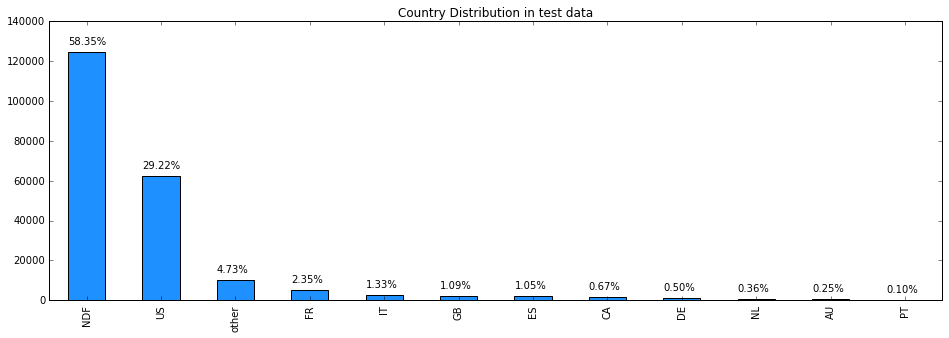

In [4]:
plt.figure(figsize=(16,5))
country_dist = train_data["country_destination"].value_counts()
ax = country_dist.plot.bar(title="Country Distribution in test data", color='dodgerblue')

for p in ax.patches:
    pct = format(p.get_height()/sum(country_dist), '.2%')
    ax.annotate(pct, xy=(p.get_x(), p.get_height()+4000))

### Analysis of age data
We'll start with the assumption that valid age ranges should be between 18-100 since the minimum age according to the Terms of Service is 18. Any values outside of this range should be cleaned into valid values or set to 0 as invalid.

The chart below shows a histogram of all age data.

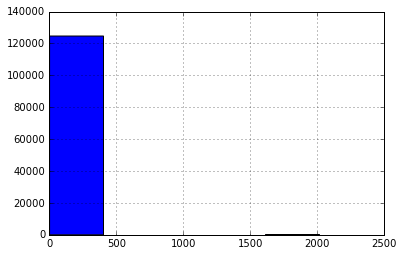

In [5]:
# Get all age values that are greater than zero.
GTE_zero_age = train_data[train_data.age >= 0].age
# Plot a histogram of these values.
GTE_zero_age.hist(bins=5)

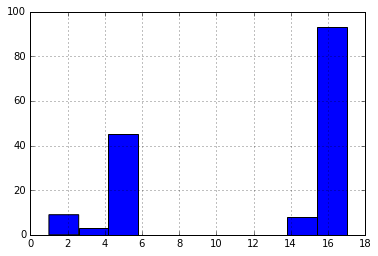

In [6]:
# Get all age values that are between 0 and 18.
under_18 = GTE_zero_age[GTE_zero_age < 18]
under_18.hist()

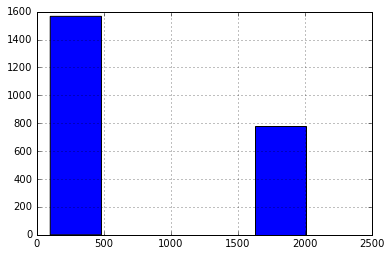

In [7]:
# From this, we can see that there are many large values.
# Assuming anything above 100 is not a valid, let's plot the histogram of those values.
GT_150 = train_data[train_data.age > 100].age
GT_150.hist(bins=5)
# We can't make much sense out of values between 100-1915 so
# those should be treated as invalid values as well.

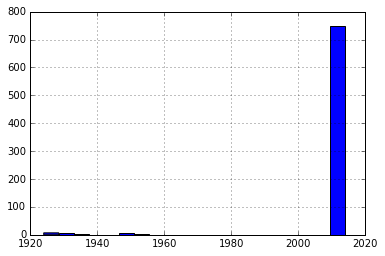

In [8]:
# Let's look more closely at those values greater than 1915.
GT_1915 = train_data[train_data.age > 1915].age
GT_1915.hist(bins=20)
# We have some values between 1915 and 1997 which we can
# assume could be birth years.
# The large number of values > 1997 are likely the current
# year the user registered.

#### Cleaning Age Data
Based on our analysis, we wrote a function to re-code invalid age data as appropriate. This function is applied to both the training and test datasets.

In [3]:
# Helper function to clean up the age data
def CleanAgeData(df):
    age_data = df.age
    # Set missing values to -1.
    age_data = age_data.fillna(0)
    # Set invalid values to 0.
    # Values between 0-18 are considered invalid.
    age_data[age_data.isin(range(0,18))] = 0
    # Values between 100-1915 are considered invalid.
    age_data[age_data.isin(range(101,1915))] = 0
    # Values >2010 are considered invalid.
    age_data[age_data > 1997] = 0
    # Compute age for values between 1915-1997.
    age_data[age_data.isin(range(1915,1998))] = 2015 - age_data[age_data.isin(range(1915,1998))]
    return age_data

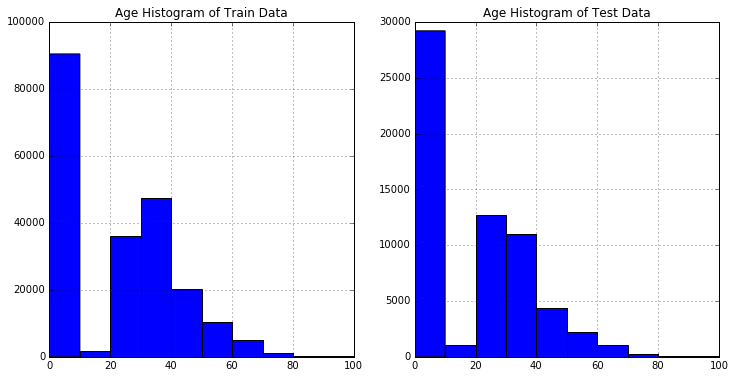

In [10]:
# Clean up training and test age data and plot cleaned data.
plt.figure(figsize=(12, 6))
train_age_data = CleanAgeData(train_data)
plt.subplot(1, 2, 1)
train_age_data.hist(bins=10)
plt.title("Age Histogram of Train Data")

test_age_data = CleanAgeData(test_data)
plt.subplot(1, 2, 2)
test_age_data.hist(bins=10)
plt.title("Age Histogram of Test Data")

### Analysis of Date Data

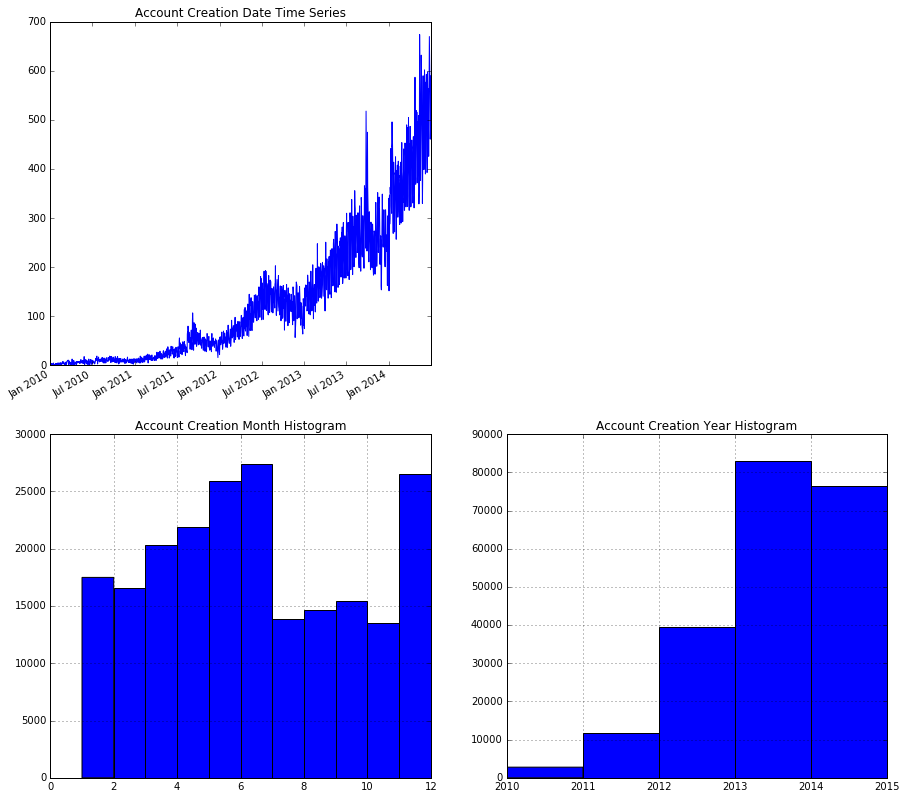

In [11]:
# Plot account created time series data.
plt.figure(figsize=(15, 15))
account_created_data = pd.to_datetime(train_data.date_account_created).value_counts()
plt.subplot(2, 2, 1)
account_created_data.plot()
plt.title("Account Creation Date Time Series")

# Plot account created month data.
account_created_month = pd.to_datetime(train_data.date_account_created).dt.month
plt.subplot(2, 2, 3)
account_created_month.hist(bins=range(1,13))
plt.title("Account Creation Month Histogram")

# Plot account created year data.
account_created_year = pd.to_datetime(train_data.date_account_created).dt.year
ax = plt.subplot(2, 2, 4)
account_created_year.hist(bins=[2010,2011,2012,2013,2014,2015])
ax.ticklabel_format(useOffset=False)
plt.title("Account Creation Year Histogram")

### Analysis of Session Data
Airbnb provided other data in addition to the training and test datasets. The "Session" dataset contains web sessions log for the users. The activity of a user could be indicative of intention to book. Ultimately, our attempts to include this data in the models did not add value.

In [5]:
# Import sessions data and summarize.
sessions= pd.read_csv('data/sessions.csv')

print(sessions.apply(lambda x: x.nunique(),axis=0))
print ""
sessions.head()

user_id          135483
action              359
action_type          10
action_detail       155
device_type          14
secs_elapsed     337661
dtype: int64



,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


In [8]:
# Aggregate sessions data to the user level.
grpby = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grpby.columns = ['user_id','secs_elapsed']

action_type = pd.pivot_table(sessions, index = ['user_id'],
                             columns = ['action_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()
device_type = pd.pivot_table(sessions, index = ['user_id'],
                             columns = ['device_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()

sessions_data = pd.merge(action_type,device_type,on='user_id',how='inner')
sessions_data = pd.merge(sessions_data,grpby,on='user_id',how='inner')

# Join session data with train and test data.
joined_train_data = pd.concat([train_data, sessions_data], axis=1)
joined_test_data = pd.concat([test_data, sessions_data], axis=1, join='inner')

sessions_data.head()

,user_id,-unknown-_x,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,...,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,secs_elapsed
0,00023iyk9l,0,1,0,4,9,1,0,1,0,...,0,36,0,0,0,0,0,4,0,867896
1,0010k6l0om,5,0,0,16,9,0,0,1,0,...,0,63,0,0,0,0,0,0,0,586543
2,001wyh0pz8,6,0,0,66,2,0,0,0,3,...,0,0,0,0,0,0,0,0,0,282965
3,0028jgx1x1,1,0,0,9,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,297010
4,002qnbzfs5,184,1,0,140,140,16,0,0,15,...,0,0,0,0,0,0,0,775,0,6487080


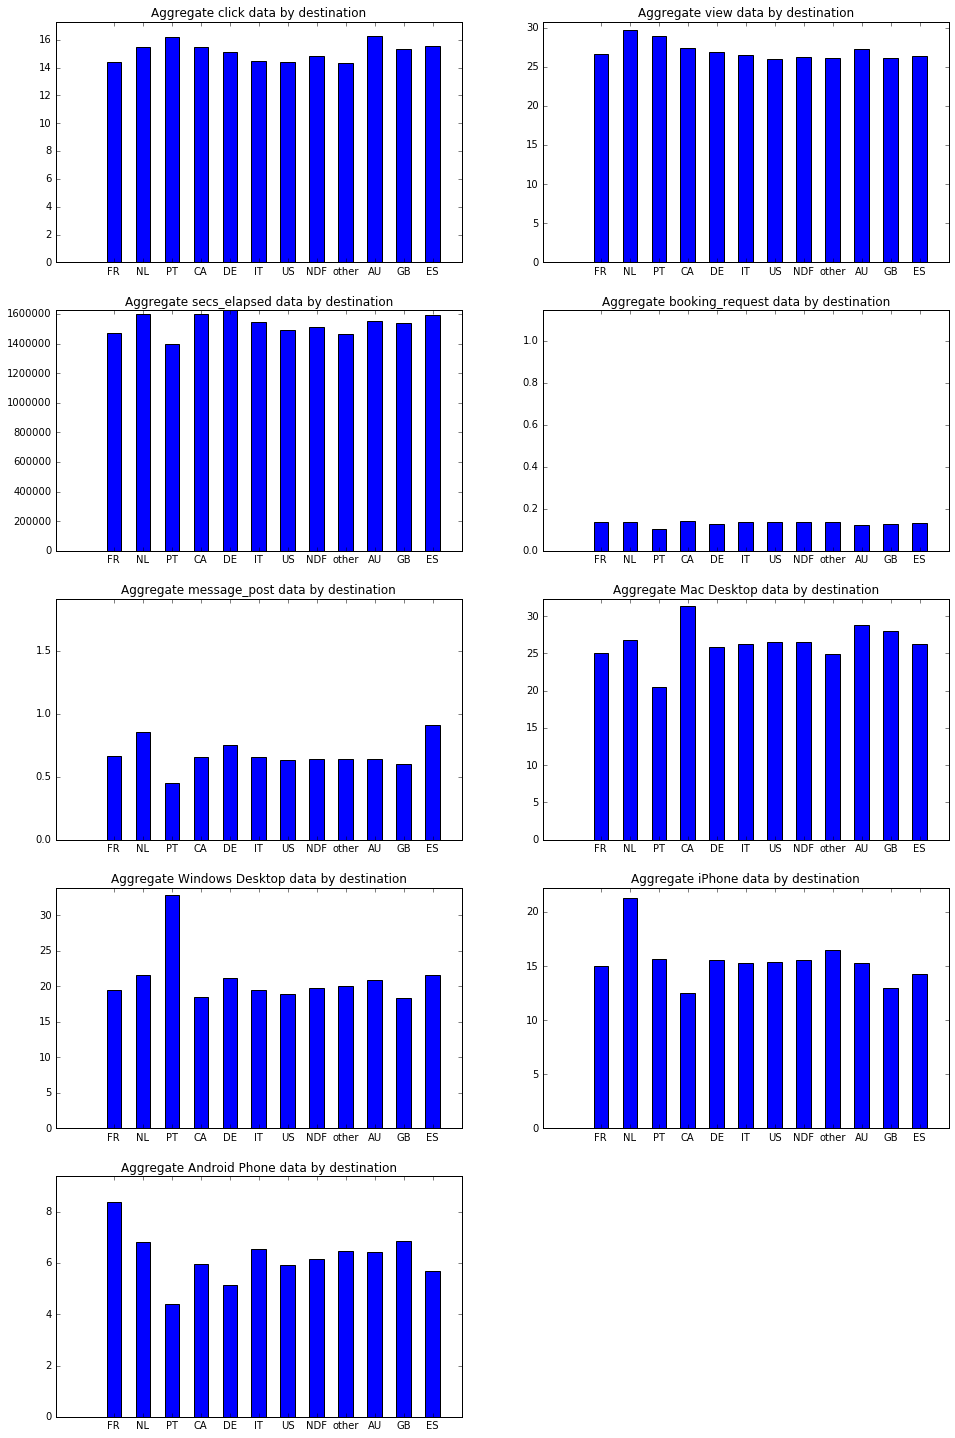

In [14]:
#Summary charts of Session Data by Country Destination
def SessionDataHist(column, plt_index):
    columns_to_extract = ['country_destination', column]
    agg_data = joined_train_data[columns_to_extract].groupby(
        ['country_destination'])[column].mean().reset_index()
    agg_dict = dict(zip(agg_data['country_destination'], agg_data[column]))
    X = np.arange(len(agg_dict))
    
    plt.subplot(5, 2, plt_index)
    plt.bar(X, agg_dict.values(), align='center', width=0.5)
    plt.xticks(X, agg_dict.keys())
    ymax = max(agg_dict.values()) + 1
    plt.ylim(0, ymax)
    plt.title("Aggregate {0} data by destination".format(column))

plt.figure(figsize=(16, 25))
# Choose some interesting columns to plot.
columns_to_plot = ['click', 'view', 'secs_elapsed', 'booking_request',
                   'message_post', 'Mac Desktop', 'Windows Desktop',
                   'iPhone', 'Android Phone']
for i,column in enumerate(columns_to_plot):
    SessionDataHist(column, i+1)

## Data Preparation and Cross-Validation

### Feature Engineering
We created a function to extract only the relevant features we intended to use in the models. This allowed us to easily add and remove features as necessary. It was also helpful to contain all our feature selection methods in a single location in the notebook.

In [9]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Encode categorical variables into N numeric classes
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data, enc_label.fit_transform(categorical_values[:,i])))

    # Add cleaned version of age data to features.
    age_data = CleanAgeData(data)
    age_buckets = age_data.divide(5).apply(np.floor)
    # Add age data to feature set.
    features_data = np.column_stack((features_data, np.array(age_buckets)))
 
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

In [10]:
# Extract and format features for training and test data.
train_data_x = ExtractFeatures(joined_train_data)
test_data_x = ExtractFeatures(joined_test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


### Training and Development Data
We further segemented our training data into Training and Development data sets with an 80/20 split. This was done to test the performance of our models without making a submission to the Kaggle competition.

In [11]:
# Split train data into training and dev sets.
train_data_size = (len(train_data_x))/5*4
train_x, train_y = train_data_x[:train_data_size], train_data_y[:train_data_size]
dev_x, dev_y= train_data_x[train_data_size:], train_data_y[train_data_size:]

# save dev id to be used in score calculation
dev_id = np.array(train_data["id"][train_data_size:])
dev_dict = dict(zip(dev_id, dev_y))

print train_x.shape, train_y.shape
print dev_x.shape, dev_y.shape, dev_id.shape

(170760, 6) (170760,)
(42691, 6) (42691,) (42691,)


### Scoring Functions
The Airbnb competition judged the accuracy of the top 5 predictions of a model, rewarding more points to a correct prediction in the 1st prediction than the 5th. The default model accuracy functions could not simulate this scoring system, so we had to build our own for cross-validation.

#### Predict Top 5
A helper function to return top 5 prediction results in descending order per example. Takes as inputs a trained model and a target data set.

In [12]:
def Predict_Top5(m, target='dev'):
    
    ds = dev_x
    if target == 'test': ds = test_data_x
        
    prob_est = m.predict_proba(ds)
    predictions = []
    
    for i, example in enumerate(prob_est):
        sorted_scores = np.sort(example)
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = example.tolist().index(score)
            
            if target == 'dev':
                predictions.append((dev_id[i], m.classes_[index_of_score]))
            elif target == 'test':
                predictions.append((test_data["id"][i], m.classes_[index_of_score]))
    
    return predictions

#### Final Score
Replicates the discounted cumulative gain (DCG) score based on Kaggle evaluation document

In [13]:
def FinalScore(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            #scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    #scores.append((cur_id, dcg))
    
    return score/num_pred
    #return scores

#### Dump
Built on top of DCG score function, Dump outputs more summary statistics around the predicted data

In [14]:
def Dump(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    scores.append((cur_id, dcg))
    
    #Output more info for error analysis
    dev_scores = dict(scores)
    dump = []
    temp_list = []
    for i in range(len(dev_x)):        
        temp_list = [dev_id[i], dev_y[i], dev_scores[dev_id[i]]]        
        dump.append(dev_x[i].tolist() + temp_list) 

    output = pd.DataFrame(dump, columns=["gender", "signup_method", "language", "first_device_type", 
                                         "first_browser", "age", "id", "country","score"])
    output.to_csv("dev_x_score.csv", index=False)
    
    buckets = [1.0, 0.6309, 0.5, 0.4307, 0.3869, 0.0]    
    plt.figure(figsize=(16,14))
    
    for i in range(len(buckets)):    
        pred_count = output[abs(output.score - buckets[i]) < 0.001].country.value_counts()    
        plt.subplot(2, 3, i+1)
    
        t,c = '',''
        if(i<5):
            t = "Correct prediction on attempt " + str(i+1)
            c = "dodgerblue"
        else:
            t = "Incorrect prediction dist"
            c = 'salmon'
        
        ax = pred_count.plot.bar(title=t, color=c)
        for p in ax.patches:
            txt = str(int(p.get_height()))
            ax.annotate(txt, xy=(p.get_x(), p.get_height() + 3))
    
    print "\nDev score: %7.5f"%(score/num_pred)
    
    return 

## Model Development

### Multinomial Naive Bayes


In [24]:
# Train Naive Bayes Model.
mnb = MultinomialNB()
mnb.fit(train_x, train_y)
predictions = mnb.predict(dev_x)
print "Accuracy: {0}".format(mnb.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(mnb, 'dev')))

Accuracy: 0.592794734253
F1 score: 0.564509554404
DCG score: 0.807262139384


In [25]:
predictions = Predict_Top5(mnb, 'test')
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 6
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Dev score: 0.80726


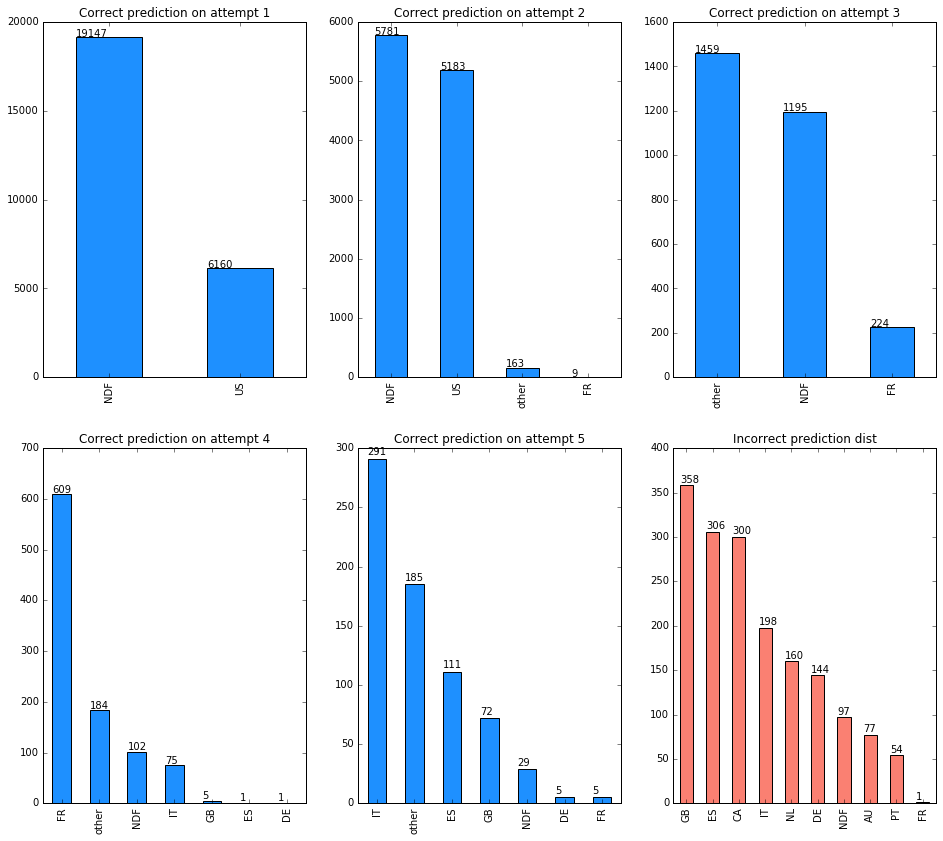

In [26]:
Dump(Predict_Top5(mnb, 'dev'))

### Logistic Regression

In [27]:
# Train Logistic Regression Model.
lr = LogisticRegression(penalty='l2')
lr.fit(train_x, train_y)
lr_predictions = lr.predict(dev_x)
print "Accuracy: {0}".format(lr.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,lr_predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(lr, 'dev')))

Accuracy: 0.627673280082
F1 score: 0.558686616831
DCG score: 0.825759509811


In [28]:
predictions = Predict_Top5(lr, 'test')
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 6
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Dev score: 0.82576


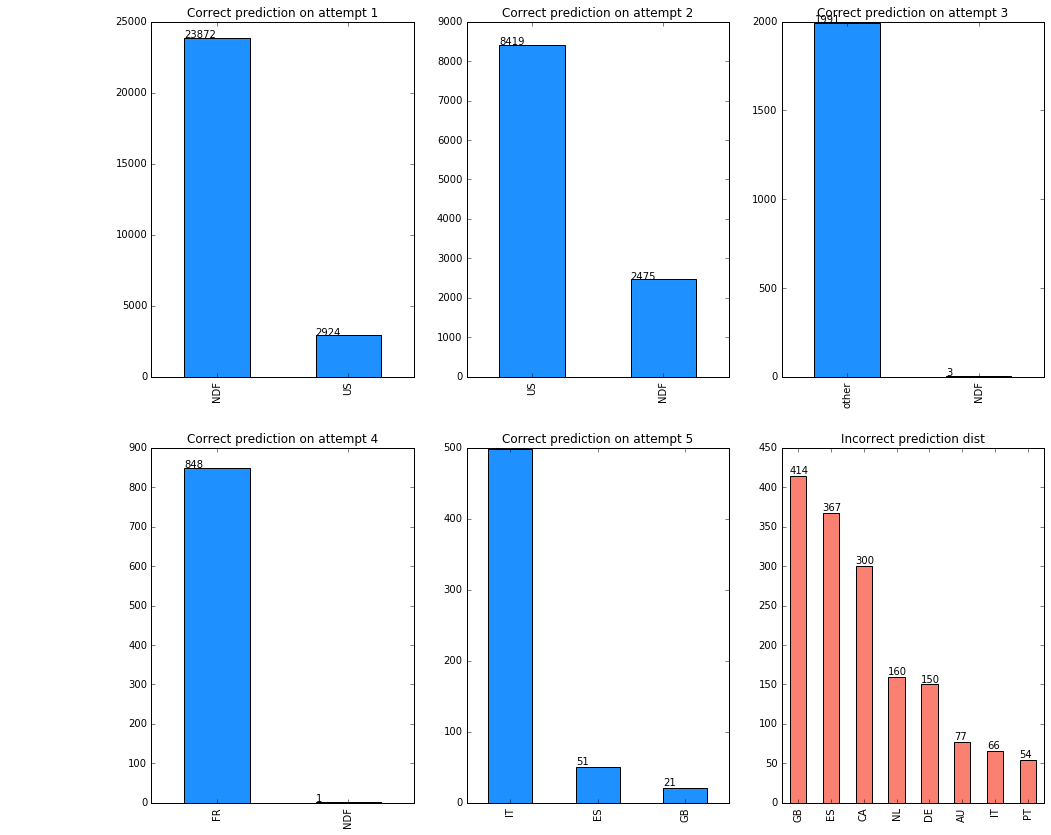

In [29]:
Dump(Predict_Top5(lr, 'dev'))

### Random Forest

In [30]:
# Train Random forest.
rf= RandomForestClassifier(n_estimators=50)
rf.fit(train_x, train_y)
rf_predictions = rf.predict(dev_x)
print "Accuracy: {0}".format(rf.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,rf_predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(rf, 'dev')))

Accuracy: 0.65001991052
F1 score: 0.606365720799
DCG score: 0.829293778412


In [31]:
predictions = Predict_Top5(rf, 'test')
output4 = pd.DataFrame(predictions, columns=["id", "country"])
version = 4
output4.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Dev score: 0.82929


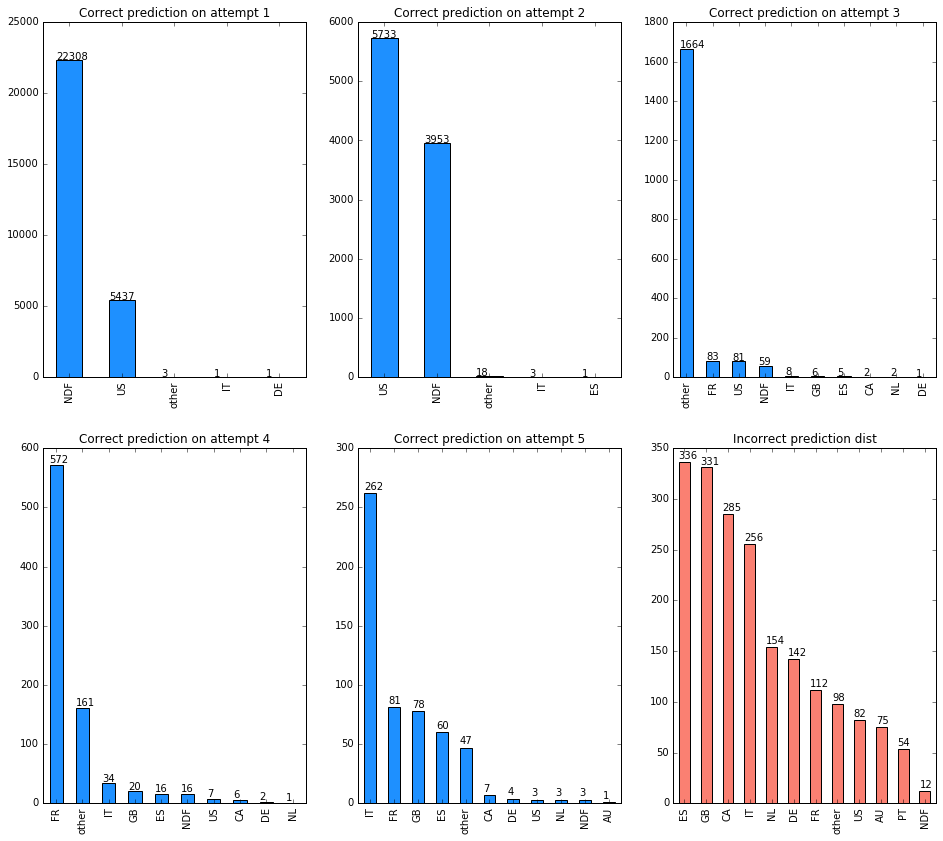

In [32]:
Dump(Predict_Top5(rf, 'dev'))

### Voting Classifier

In [33]:
# Try voting ensemble
vc = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc.fit(train_x, train_y)
vc_predictions = vc.predict(dev_x)
print "Accuracy: {0}".format(vc.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,vc_predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(vc, 'dev')))

Accuracy: 0.650441545056
F1 score: 0.603221306402
DCG score: 0.833478664959


In [34]:
predictions = Predict_Top5(vc, 'test')
output = pd.DataFrame(predictions, columns=["id", "country"])
version = 7
output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Dev score: 0.83348


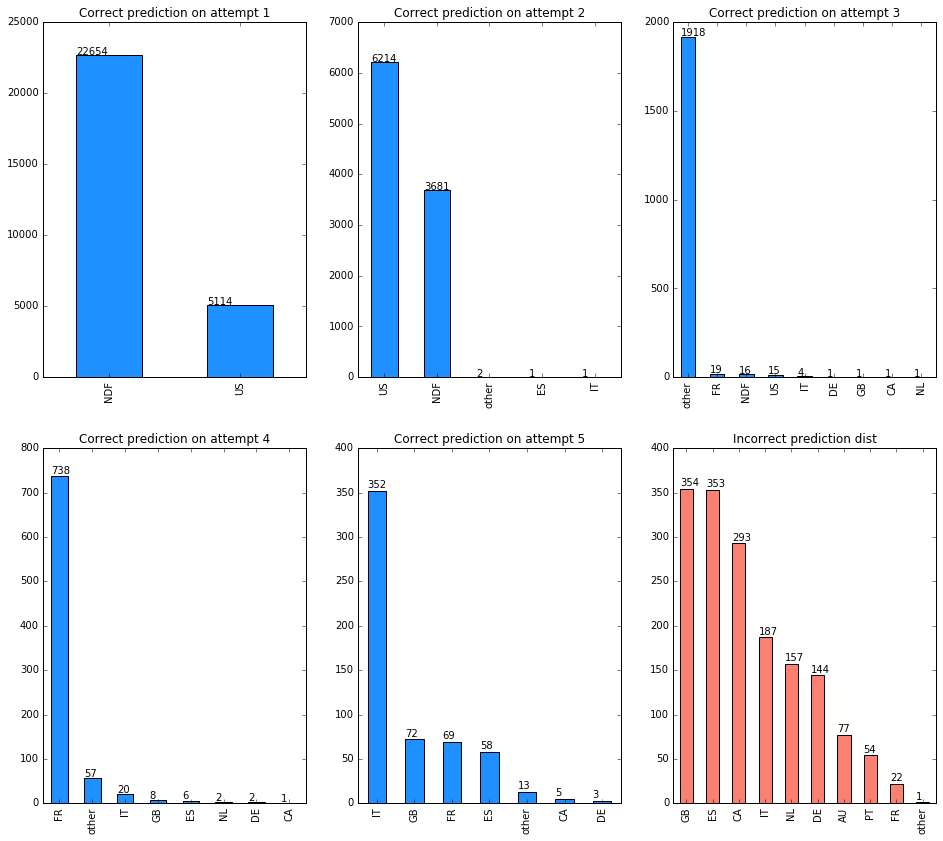

In [35]:
Dump(Predict_Top5(vc, 'dev'))

### Log of Improvements
1. Multinomial NB  (Baseline)
Baseline score: 0.63168  
Baseline rank: 1304  
2. Multinomial NB with Top 5 predictions  
Score: 0.79584  
Rank: 1142
3. Logistic Regression with Top 5 predictions  
Score: 0.85894  
Rank: 1049
4. Random Forest with Top 5 predictions  
Score: 0.81781  
Rank: 1138  
5. Logistic Regression with Age data clean-up  
Score improvement: 0.85970  
Rank improvement: 1044  
6. Soft voting with Logistic Regression and Random Forest   
Score improvement: 0.86252  
Rank improvement: 1032

## Project Challenges

### Imbalanced Data
The biggest challenge to the model was the imbalance of the class data. 2 destinations (NDF and US) represent 90% of the data. We attempted to oversample these classeses using the Synthetic Minority Oversampling Technique (SMOTE). This method was successful in improving the accuracy of the minority classes, but these gains were offset by lowered accuracy on the majority classes due to their large size.

One area of proposed future research would be to investigate other methods of handling imbalanced data that could improve accuracy on the minority classes without such detrimental effects to the majority classes.


#### SMOTE implementation
The following SMOTE function was based on this source: http://comments.gmane.org/gmane.comp.python.scikit-learn/5278

In [36]:
def SMOTE(T, N, k):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : array, shape = [(N/100) * n_minority_samples, n_features]
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    n_synthetic_samples = N * n_minority_samples
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in xrange(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        for n in xrange(N):
            nn_index = random.choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = random.choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    
    return S

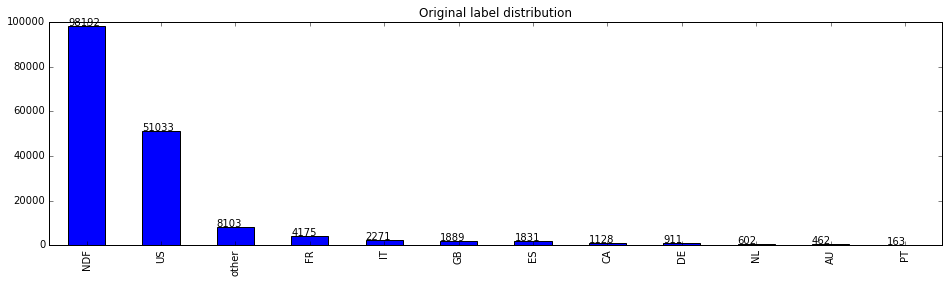

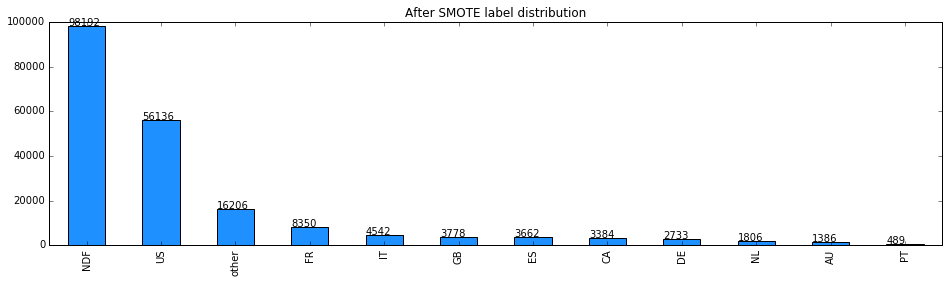

In [37]:
smote_countries = [('US',1), ('other',1),('FR',1),('IT',1),('GB',1),('ES',1),\
                       ('CA',2),('DE',2),('NL',2),('AU',2),('PT',2)]
    
plt.figure(figsize=(16,4))
country_dist = pd.Series(train_y).value_counts()
ax = country_dist.plot.bar(title="Original label distribution", color='b')
for p in ax.patches:
    txt = str(int(p.get_height()))
    ax.annotate(txt, xy=(p.get_x(), p.get_height() + 5))
    

for i, c in enumerate(smote_countries):
    country, N = c[0], c[1]

    train_x_country = train_x[train_y == country]

    #use 10% of US label as 1 unit for SMOTE
    if country == 'US':
        size = train_x_country.shape[0] / 10
        train_x_country = train_x_country[:size]

    #SMOTE(minority data, new data size, NN steps)
    #To double minority data example size, set N=1
    #NN default = 5 neighbours
    train_x_new =  SMOTE(train_x_country,N*100,5)

    #Append new data to train_x
    train_x = np.vstack((train_x, train_x_new))

    #Append label to train_y
    new_label = []
    for i in range(N * len(train_x_country)):
        new_label.append(country)
    train_y = np.concatenate((train_y, np.array(new_label)))


plt.figure(figsize=(16,4))
country_dist = pd.Series(train_y).value_counts()
ax = country_dist.plot.bar(title="After SMOTE label distribution", color='dodgerblue')
for p in ax.patches:
    txt = str(int(p.get_height()))
    ax.annotate(txt, xy=(p.get_x(), p.get_height() + 5))


Dev score: 0.83384


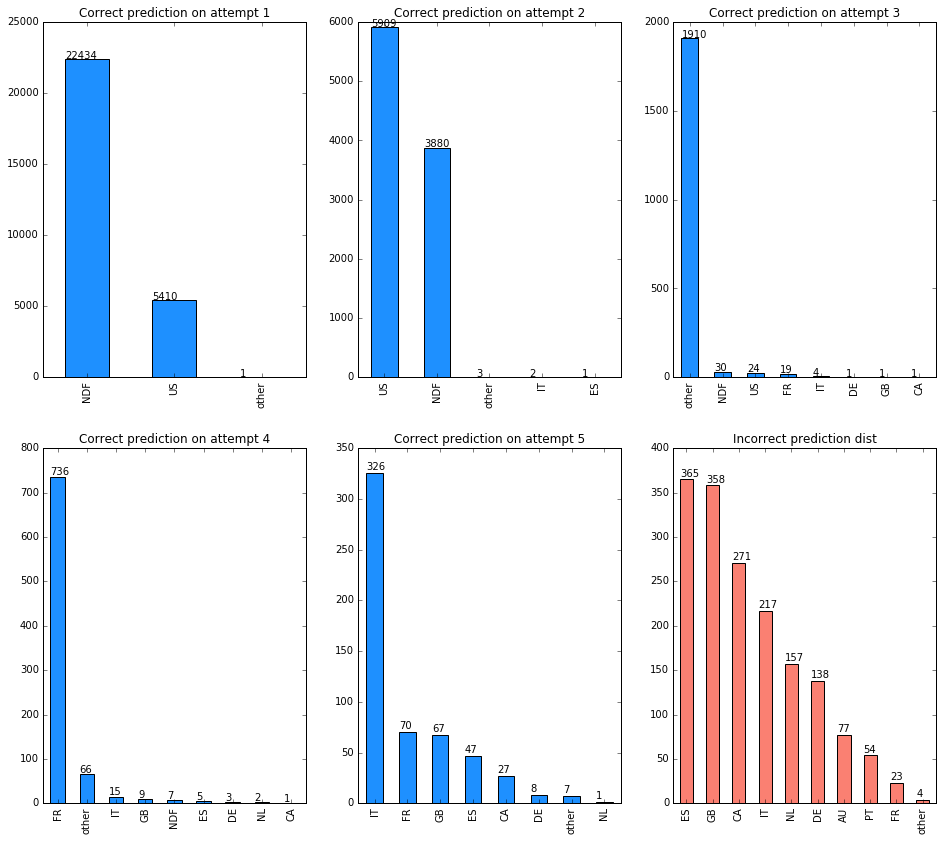

In [38]:
# Train Logistic Regression Model with SMOTE data
lr_sm = LogisticRegression(penalty='l2')
lr_sm.fit(train_x, train_y)

# Train Random forest SMOTE data
rf_sm= RandomForestClassifier(n_estimators=50)
rf_sm.fit(train_x, train_y)

# Voting ensemble with models on SMOTE Data
vc_sm = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc_sm.fit(train_x, train_y)
vc_sm_predictions = rf.predict(dev_x)

Dump(Predict_Top5(vc_sm, 'dev'))

### Model Simplicity vs Model Accuracy
The highest score we were able to achieve was 0.86252, which places us at the 1032nd spot in the leaderboard. The number 1 spot had a score of 0.88697, or 2.4% more accurate. One of the top placers described his model architecture, which incorporated over 1,300 base features and 18 models in the first layer of the architecture alone.

This raises the question of the value of Model Accuracy versus Model Simplicity. With a simple logistic regression and 6 features, we were able to get with 3% of the score of the top spot. While for a Kaggle competition this gap is enormous, for a company Airbnb that difference might not be significant. 3% better predictions unarguable yields higher revenue, but also requires more development time and less model interpretability. This is important to consider when developing a model.

#### 3-Level Model

In [15]:
# Use LabelBinarizer to transform training labels matrix of binary values.
lb = preprocessing.LabelBinarizer()
labels_train = lb.fit_transform(train_y)
labels_dev = lb.transform(dev_y)
print lb.classes_
# Note that NDF is index 7 and US is index 10.

['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']


In [16]:
# Train Logistic Regression for NDF vs non-NDF.
lr_ndf = LogisticRegression(penalty='l2')
lr_ndf.fit(train_x, labels_train[:,7])
lr_ndf_predictions = lr_ndf.predict(dev_x)
print "NDF Logistic Regression F1 score: {0}".format(
    metrics.f1_score(labels_dev[:,7],lr_ndf_predictions,average="binary"))

NDF Logistic Regression F1 score: 0.768087041702


In [17]:
# Train models for US vs non-US.
# Get all non-NDF examples
us_train_x = np.array(
    [train_x[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0)])
us_dev_x = np.array(
    [dev_x[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0)])
us_train_y = np.array(
    [labels_train[i,10] for i in range(len(labels_train)) if (labels_train[i,7] == 0)])
us_dev_y = np.array(
    [labels_dev[i,10] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0)])

lr_us = LogisticRegression(penalty='l2')
lr_us.fit(us_train_x, us_train_y)
lr_us_predictions = lr_us.predict(us_dev_x)
print "US Logistic Regression F1 score: {0}".format(
    metrics.f1_score(us_dev_y,lr_us_predictions,average="binary"))

rf_us= RandomForestClassifier()
rf_us.fit(us_train_x, us_train_y)
rf_us_predictions = rf_us.predict(us_dev_x)
print "US Random Forest F1 score: {0}".format(
    metrics.f1_score(us_dev_y,rf_us_predictions,average="binary"))

vc_us = VotingClassifier(estimators=[ ('lr', lr_us), ('rf', rf_us)], voting='soft')
vc_us.fit(us_train_x, us_train_y)
vc_us_predictions = vc_us.predict(us_dev_x)
print "US voting F1 score: {0}".format(
    metrics.f1_score(us_dev_y,vc_us_predictions,average="binary"))

US Logistic Regression F1 score: 0.819492107069
US Random Forest F1 score: 0.812907479306
US voting F1 score: 0.818227958237


In [18]:
# Train models for classifying non NDF/US examples.
# Get all non-NDF/US examples
other_train_x = np.array(
    [train_x[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0 and labels_train[i,10] == 0)])
other_train_y = np.array(
    [train_y[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0 and labels_train[i,10] == 0)])
other_dev_x = np.array(
    [dev_x[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0 and labels_train[i,10] == 0)])
other_dev_y = np.array(
    [dev_y[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0 and labels_train[i,10] == 0)])

lr_other = LogisticRegression(penalty='l2')
lr_other.fit(other_train_x, other_train_y)
lr_other_predictions = lr_other.predict(other_dev_x)
print "Non-NDF/US logistic regression F1 score: {0}".format(
    metrics.f1_score(other_dev_y,lr_other_predictions,average="weighted"))

rf_other= RandomForestClassifier()
rf_other.fit(other_train_x, other_train_y)
rf_other_predictions = rf_other.predict(other_dev_x)
print "Non-NDF/US random forest F1 score: {0}".format(
    metrics.f1_score(other_dev_y,rf_other_predictions,average="weighted"))

vc_other = VotingClassifier(estimators=[ ('lr', lr_other), ('rf', rf_other)], voting='soft')
vc_other.fit(other_train_x, other_train_y)
vc_other_predictions = vc_other.predict(other_dev_x)
print "Non-NDF/US voting F1 score: {0}".format(
    metrics.f1_score(other_dev_y,vc_other_predictions,average="weighted"))

Non-NDF/US logistic regression F1 score: 0.0264627676823
Non-NDF/US random forest F1 score: 0.033198245925
Non-NDF/US voting F1 score: 0.0293710661287



Dev score: 0.71758


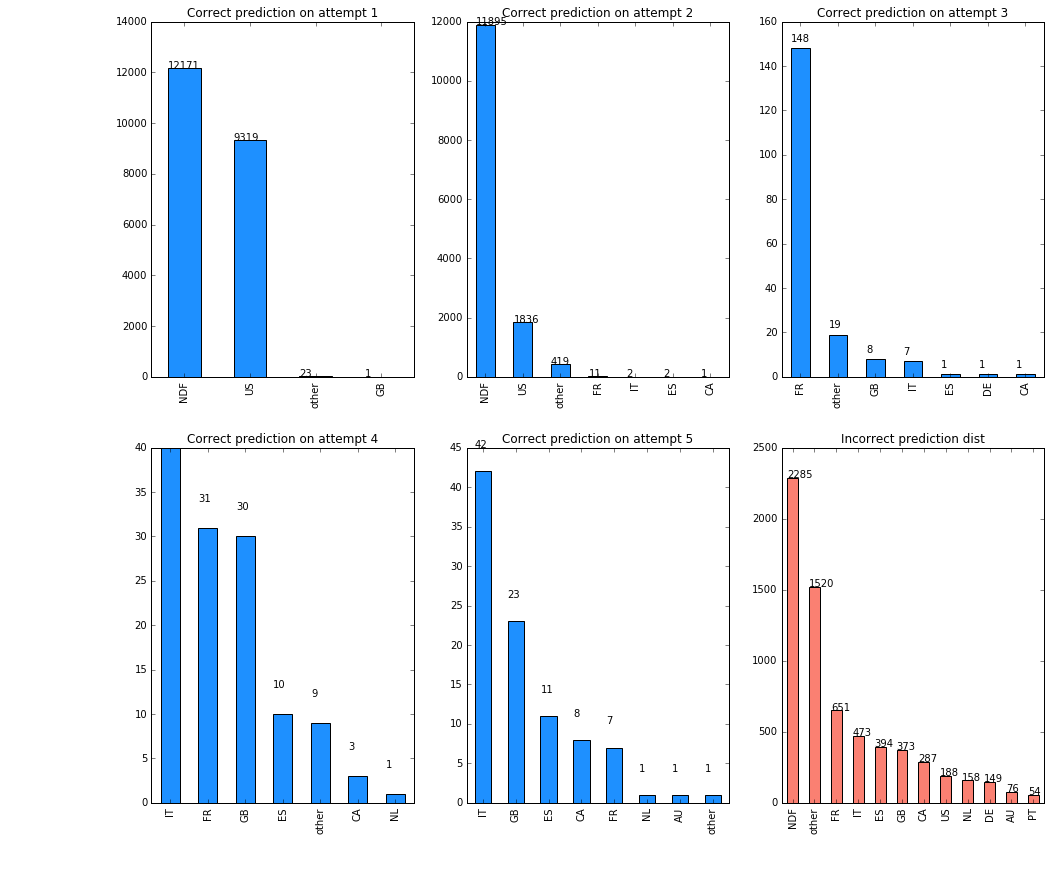

In [20]:
# Create a 3-level model using NDF, US, and other models.
# Compute accuracy on dev set.
lr_ndf_dev_prob = lr_ndf.predict_proba(dev_x)
lr_us_dev_prob = rf_us.predict_proba(dev_x)
vc_other_dev_prob = vc_other.predict_proba(dev_x)
predictions = []
for i in range(dev_x.shape[0]):
    ndf_prob = lr_ndf_dev_prob[i][1]
    us_prob = lr_us_dev_prob[i][1]
    max_other_prob = np.max(vc_other_dev_prob[i])
    if (ndf_prob > us_prob and ndf_prob > max_other_prob):
        predictions.append((dev_id[i], 'NDF'))
        if (us_prob > max_other_prob):
            predictions.append((dev_id[i], 'US'))
        else:
            sorted_scores = np.sort(vc_other_dev_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_dev_prob[i].tolist().index(score)
                predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
    elif (us_prob > ndf_prob and us_prob > max_other_prob):
        predictions.append((dev_id[i], 'US'))
        if (ndf_prob > max_other_prob):
            predictions.append((dev_id[i], 'NDF'))
        else:
            sorted_scores = np.sort(vc_other_dev_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_dev_prob[i].tolist().index(score)
                predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
    else:
        sorted_scores = np.sort(vc_other_dev_prob[i])
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = vc_other_dev_prob[i].tolist().index(score)
            predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
Dump(predictions)

In [109]:
# Run 3-level model on test data.
lr_ndf_predictions_test = lr_ndf.predict(test_data_x)
lr_us_predictions_test = lr_us.predict(test_data_x)
vc_other_test_prob = vc_other.predict_proba(test_data_x)
predictions = []
for i in range(test_data_x.shape[0]):
    if (lr_ndf_predictions_test[i] == 1):
        predictions.append((test_data["id"][i], 'NDF'))
        if (lr_us_predictions_test[i] == 1):
            predictions.append((test_data["id"][i], 'US'))
        else:
            sorted_scores = np.sort(vc_other_test_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_test_prob[i].tolist().index(score)
                predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
    elif (lr_us_predictions_test[i] == 1):
        predictions.append((test_data["id"][i], 'US'))
        if (lr_ndf_predictions_test[i] == 1):
            predictions.append((test_data["id"][i], 'NDF'))
        else:
            sorted_scores = np.sort(vc_other_test_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_test_prob[i].tolist().index(score)
                predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
    else:
        sorted_scores = np.sort(vc_other_test_prob[i])
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = vc_other_test_prob[i].tolist().index(score)
            predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
# output8 = pd.DataFrame(predictions, columns=["id", "country"])
# version = 8
# output8.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)

# Error Analysis

In [110]:
import operator
def error_analysis(model, dev_x, dev_y):
    """
    Due to the large frequence of NDFs, the matrix needs to be normalized if we're to see anything helpful in this viz.
    """
    preds = model.predict(dev_x) ##Compute predictions given model
    labels = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']    
    ###Accuracy Statistics###
    print 'FinalScore metric value: ', FinalScore(Predict_Top5(model, 'dev'))
    print "precision answers: where we measure 'country', what fraction actually was 'country'?"
    print "recall answers: of all that were 'country', what fraction did we correctly predict 'country'?"
    print "goal is to have both high precision and recall scores"
    print 'Precision and Recall scores: \n'
    precision = []
    recall = []
    for country in labels:
        binarized_devy = dev_y == country
        binarized_preds = preds == country
        precision.append(metrics.precision_score(binarized_devy, binarized_preds))
        recall.append(metrics.recall_score(binarized_devy, binarized_preds))
    p_r_dict = {'precision':precision, 'recall':recall}
    p_r_df = pd.DataFrame(p_r_dict, index=labels)
    print p_r_df
    ###Confusion Matrix###
    c_matx = metrics.confusion_matrix(dev_y, preds)
    c_matx_n = c_matx.astype('float') / c_matx.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(c_matx_n, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ###Error count###
    sums = {}
    series = {}
    for i in range(len(c_matx)):
        sums[labels[i]] = 0
        labs = []
        data = []
        for j in range(len(c_matx[i])):
            if i != j:
                sums[labels[i]] += c_matx[i][j]
                labs.append(labels[j])
                data.append(c_matx[i][j])
        series[labels[i]] = pd.Series(data, index=labs)
        series[labels[i]].sort_values(inplace=True, ascending=False)
    sorted_sums = sorted(sums.items(), key=operator.itemgetter(1), reverse=True)
    error_counts = pd.Series([x[1] for x in sorted_sums], [x[0] for x in sorted_sums])
    print 'Error Counts: \n\n', error_counts
    ###Top 5 Error Histograms###
    plt.figure(figsize=(15, 30))
    plt_indx = 1
    for country in [x[0] for x in sorted_sums[0:5]]:
        plt.subplot(5,1,plt_indx)
        series[country].plot.bar()
        plt.title("For '" + country + "' the model incorrectly guessed...")
        plt_indx += 1

FinalScore metric value:  0.8337165886
precision answers: where we measure 'country', what fraction actually was 'country'?
recall answers: of all that were 'country', what fraction did we correctly predict 'country'?
goal is to have both high precision and recall scores
Precision and Recall scores: 

       precision    recall
AU      0.000000  0.000000
CA      0.000000  0.000000
DE      0.000000  0.000000
ES      0.000000  0.000000
FR      0.000000  0.000000
GB      0.000000  0.000000
IT      0.000000  0.000000
NDF     0.714272  0.857311
NL      0.000000  0.000000
PT      0.000000  0.000000
US      0.472340  0.459931
other   0.000000  0.000000
Error Counts: 

US       6126
NDF      3760
other    1991
FR        848
IT        564
GB        435
ES        418
CA        300
NL        160
DE        150
AU         77
PT         54
dtype: int64


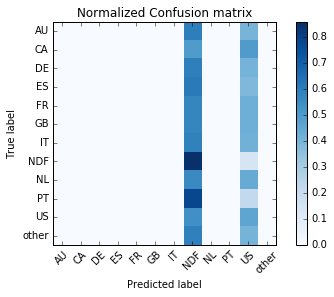

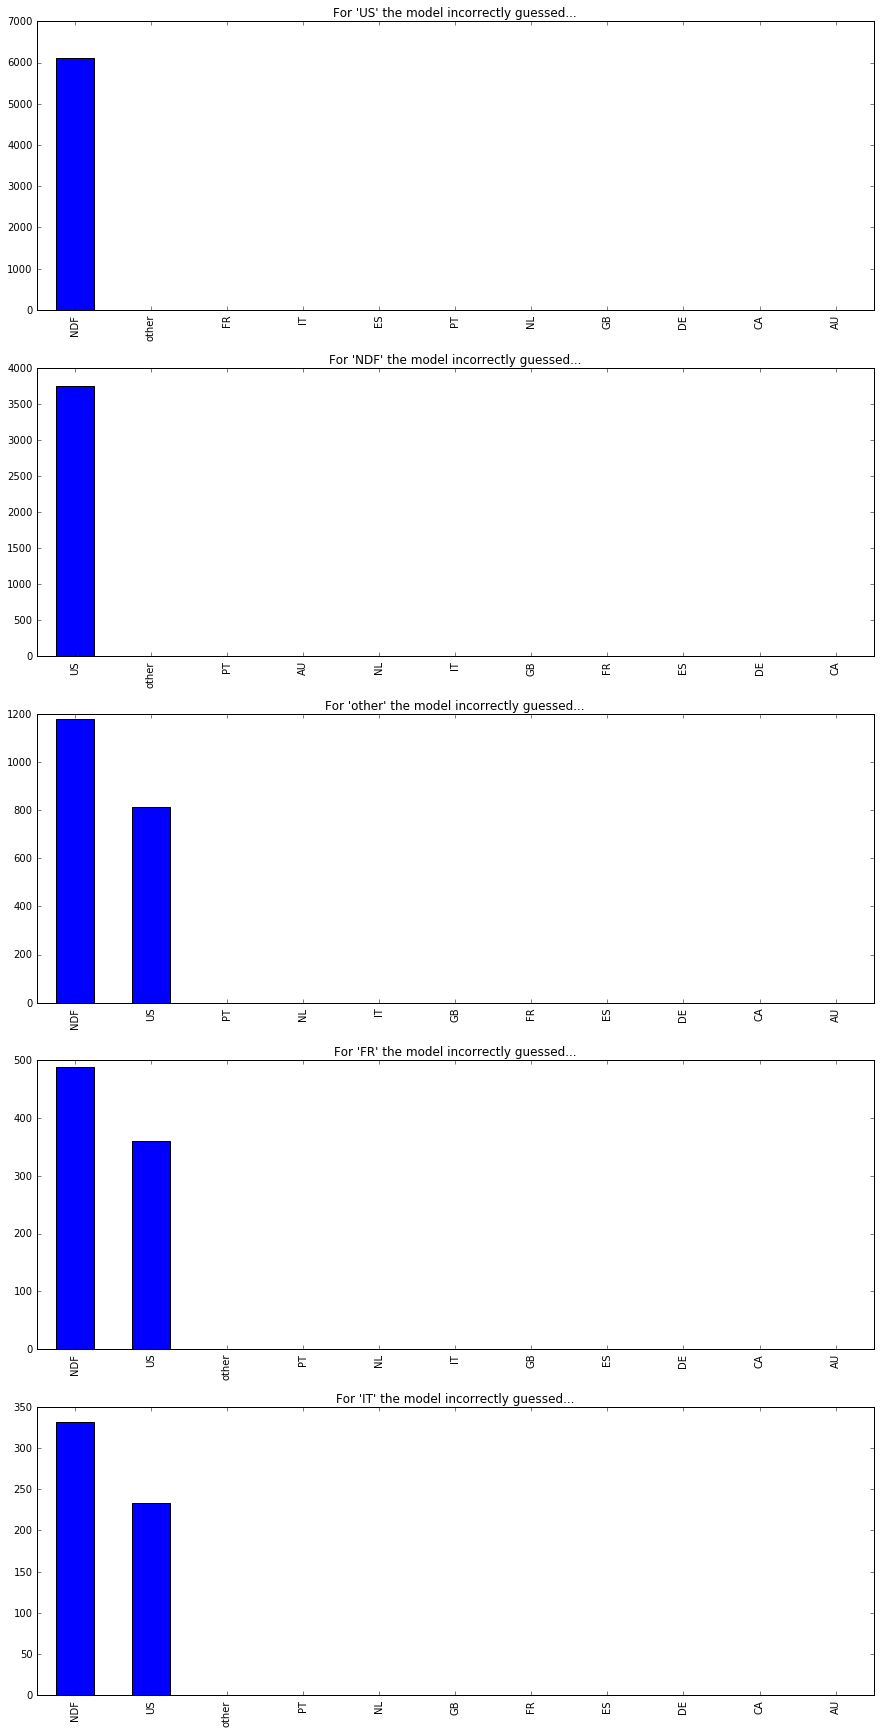

In [111]:
error_analysis(vc, dev_x, dev_y)